In [61]:
# Loading all needed packages at the start
import elastix
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import shutil

## **Fill in your own paths in the cell**




In [62]:
# to Elastix.exe
ELASTIX_PATH=r"C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\elastix.exe"
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

# to Transformix.exe
TRANSFORMIX_PATH=r"C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\transformix.exe"

# to Training Data
filepath_data = r"C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData"


### Load patient data and visualize the images


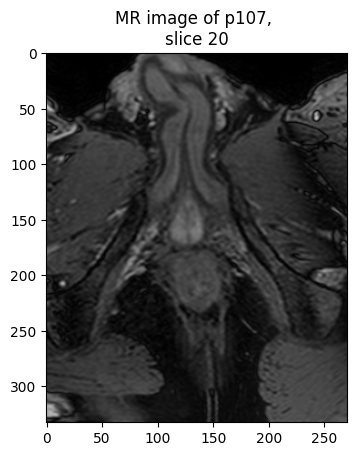

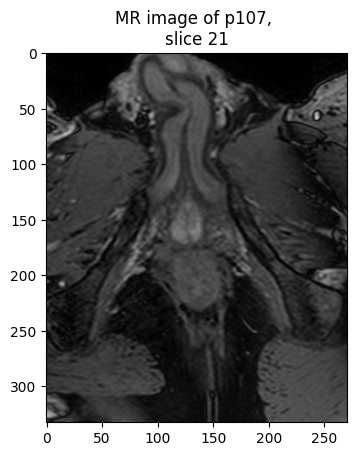

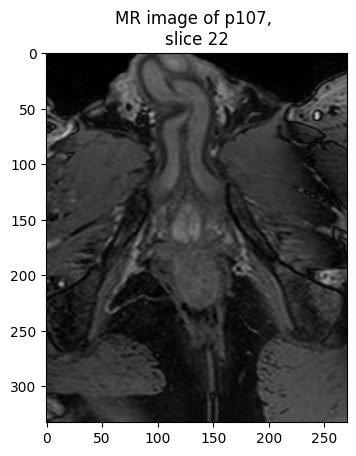

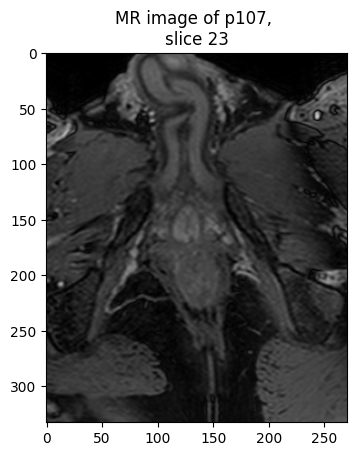

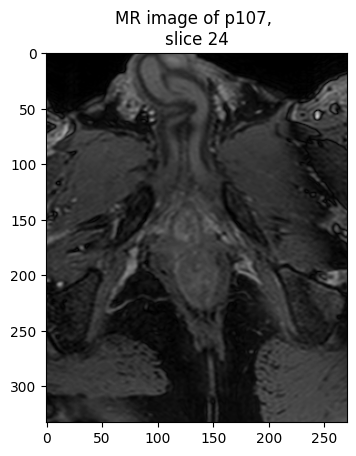

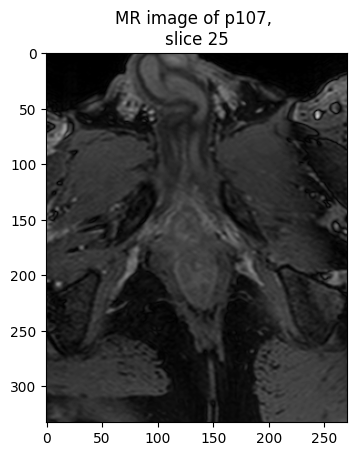

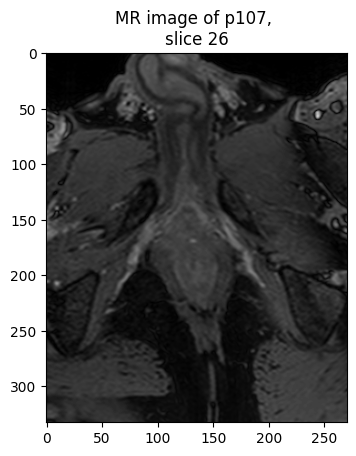

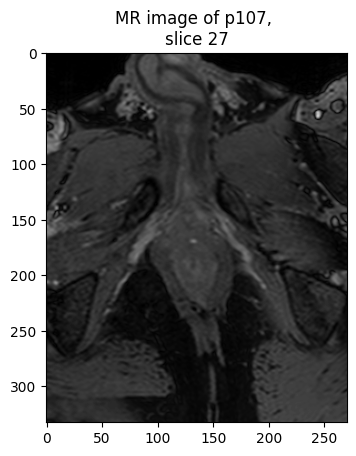

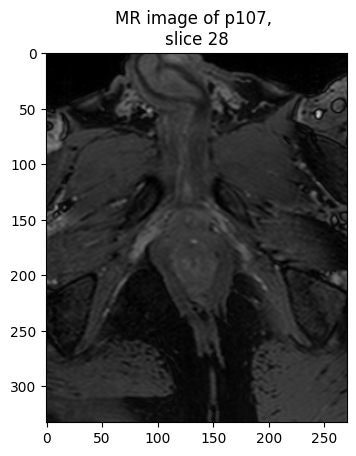

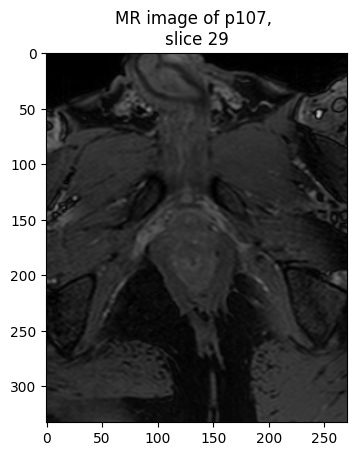

In [63]:
patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 
                    'p119', 'p120', 'p125', 'p127','p128', 'p129', 'p133', 'p135']

patient_nr = patient_nrs_list[1] 
file_p_mr = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_nr)  
file_p_mask = filepath_data+'\{}\prostaat.mhd'.format(patient_nr) 


readable_mr = imageio.imread(file_p_mr)
readable_mask = imageio.imread(file_p_mask)

for i in range(20,30):
    plt.imshow(readable_mr[i,:,:], cmap="gray") 
    plt.imshow(readable_mask[i,:,:], cmap="gray", alpha =0.2) 
    
    plt.title('MR image of {}, \nslice {}'.format(patient_nr,i))
    plt.show()

## Preparation before transformation


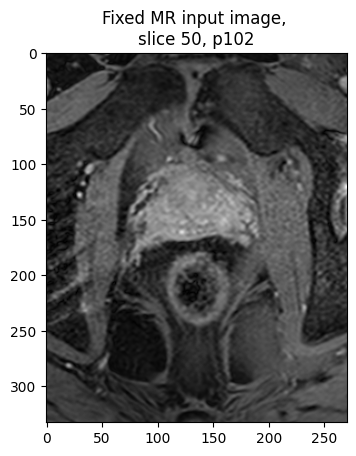

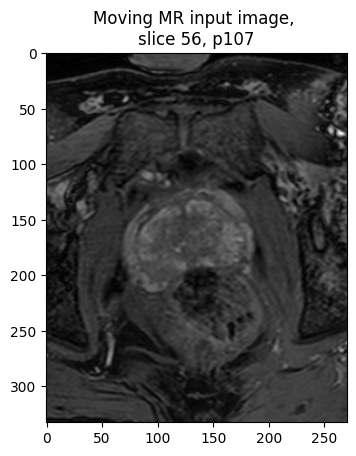

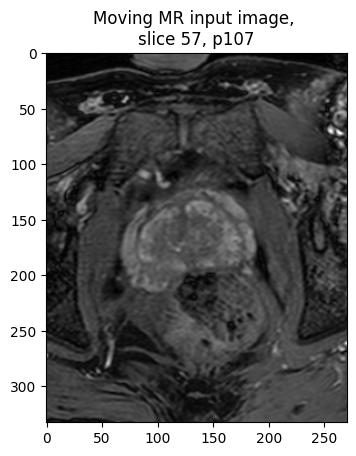

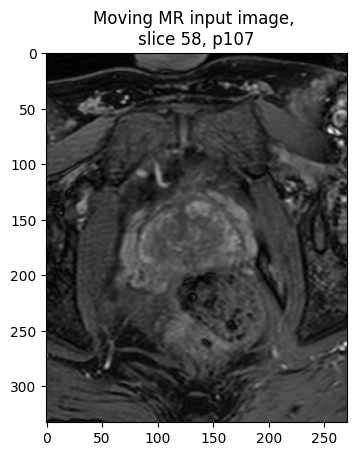

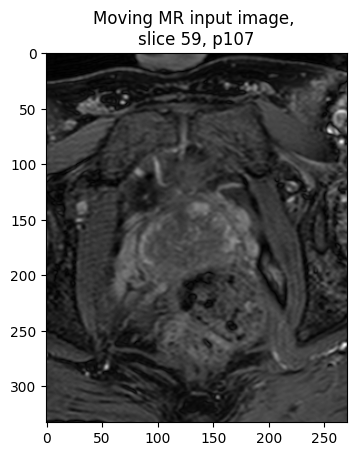

In [64]:
# instead of manually adjusting the fixed and moving patient,
# this should be linked to the script of MI in an automatic way
# register these two patients 
patient_fixed= patient_nrs_list[0] 
patient_moving= patient_nrs_list[1] 

# instead of manually adjusting the slice of the fixed image,
# this should be linked to the script of MI in an automatic way
# determine the slice of the fixed image
slice_fixed = 50

# this now contains patient_fixed and patient_moving, so needs to be adjusted later
# load the images of the two patients
fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_fixed)
moving_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_moving)

readable_fixed = imageio.imread(fixed_image_path)
readable_moving = imageio.imread(moving_image_path)

# visualize the images
plt.imshow(readable_fixed[slice_fixed,:,:], cmap='gray') 
plt.title('Fixed MR input image, \nslice {}, {}'.format(slice_fixed, patient_fixed))
plt.show()

# instead of manually adjusting this range, this should be the range of the moving slices
for i in range(56,60):
    plt.imshow(readable_moving[i,:,:], cmap='gray') 
    plt.title('Moving MR input image, \nslice {}, {}'.format(i, patient_moving))
    plt.show()


In [52]:
## THIS ONE BECOMES OBSOLETE BECAUSE A FUNCTION IS CREATED INSTEAD!

# create a 2D image of each slice in the 3D image

# in fixed_image_path and moving_image_path we use patient_fixed and patient_moving, so needs to be adjusted later
itk_image_fixed = sitk.ReadImage(fixed_image_path)
itk_image_moving = sitk.ReadImage(moving_image_path)

for i in range(86): 
    itk_img_array = sitk.GetArrayFromImage(itk_image_fixed)
    slice = sitk.GetImageFromArray(itk_img_array[i,:,:])
    path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
    sitk.WriteImage(slice,path_fixed)
    
    itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
    path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    sitk.WriteImage(slice,path_moving)
      


In [65]:
def create2DImages(fixed_image_path, moving_image_path):
    """
    Create a 2D image of each slice in the 3D image.
    
    input: 
    fixed_image_path: the path to the fixed image slice. 
    moving_image_path: the path to the moving image slices.
    
    output:
    - 
    
    """
    itk_image_fixed = sitk.ReadImage(fixed_image_path)
    itk_image_moving = sitk.ReadImage(moving_image_path)
    
    # I kept the for-loop since one patient always contains 86 slices and it is so fast that I don't think it is necessary
    # to only create images for certain slices
    for i in range(86): 
        # fixed image
        itk_img_array = sitk.GetArrayFromImage(itk_image_fixed)
        slice = sitk.GetImageFromArray(itk_img_array[i,:,:])
        path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
        sitk.WriteImage(slice,path_fixed)
    
        # moving image
        itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
        slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
        path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
        sitk.WriteImage(slice,path_moving)
        


In [66]:
create2DImages(fixed_image_path, moving_image_path)

# B SPLINES TRANSFORMATION


In [69]:
# define the path to the bsplines parameter file
parameter_file_bsplines = os.path.join(filepath_data,'parameters_penalty.txt')

# currently it says slice_fixed, but this should be changed accordingly when it is combined with MI script
# define the path to the slice of the fixed image
path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60): 
    # define the path to the slice of the moving image
    path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    
    # create a folder to store the results files
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    

    # apply the bspline transformation
    el.register(
    fixed_image=path_fixed,
    moving_image=path_moving,  
    parameters=[parameter_file_bsplines],
    output_dir=output_file_path_bspline)
    

C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\elastix.exe -f C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\p102_slice50.mhd -m C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p107\p107_slice56.mhd -p C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\parameters_penalty.txt -out C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_56
C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\elastix.exe -f C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\p102_slice50.mhd -m C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p107\p107_slice57.mhd -p C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingDa

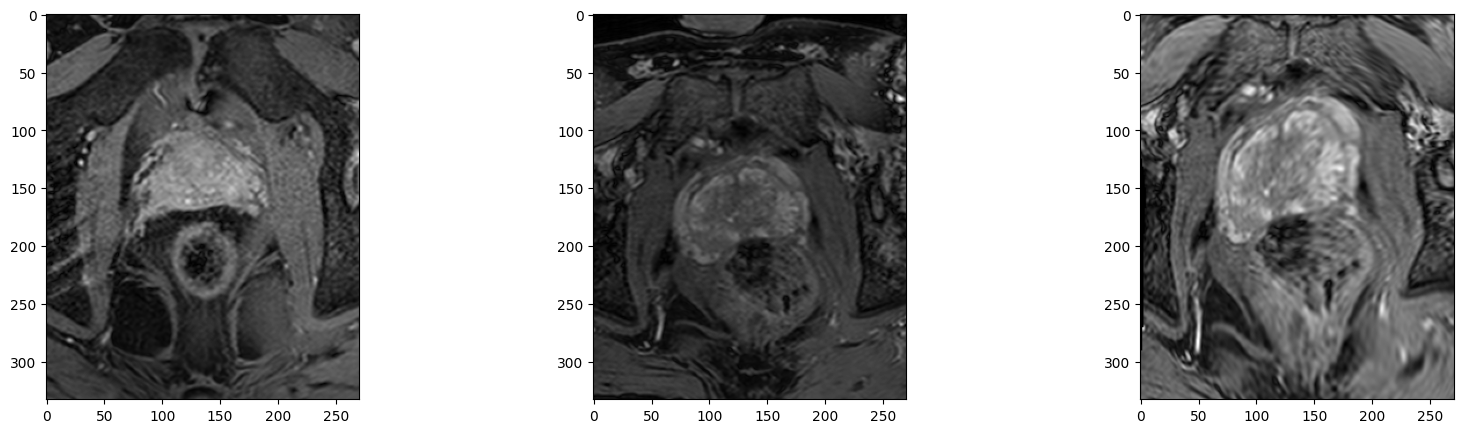

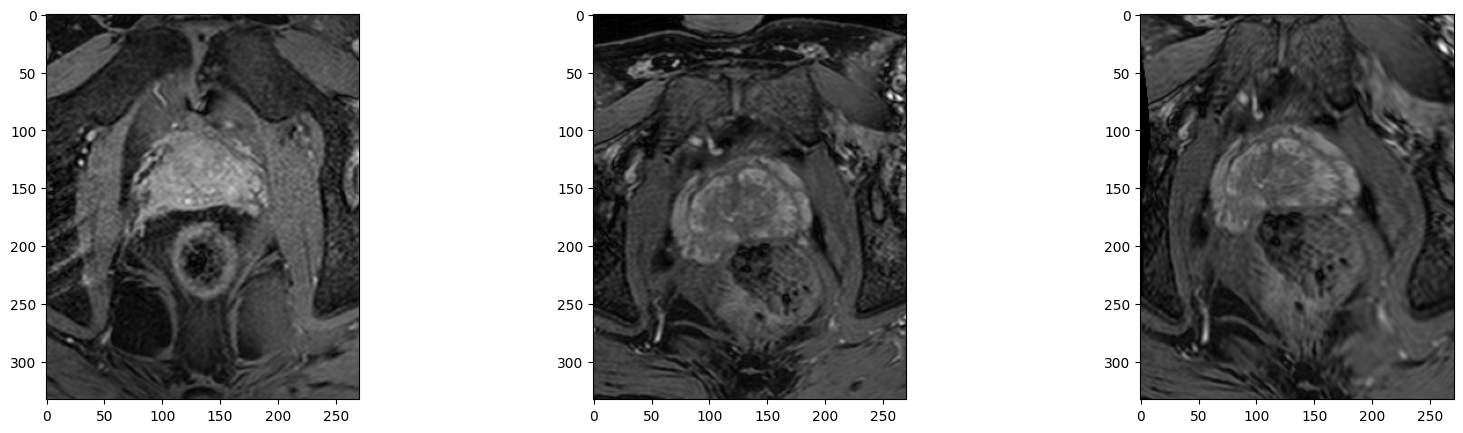

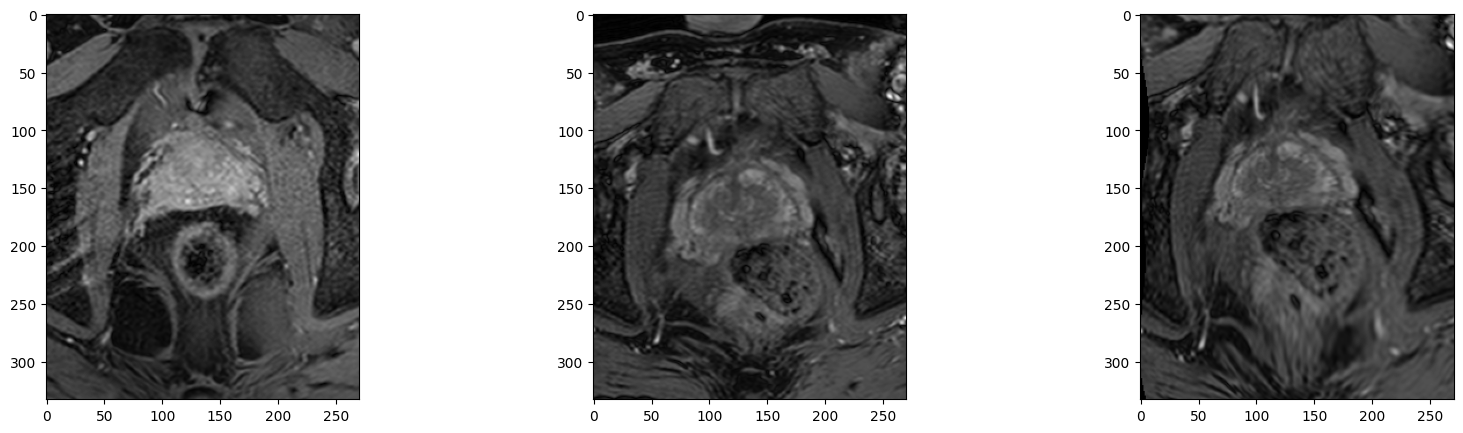

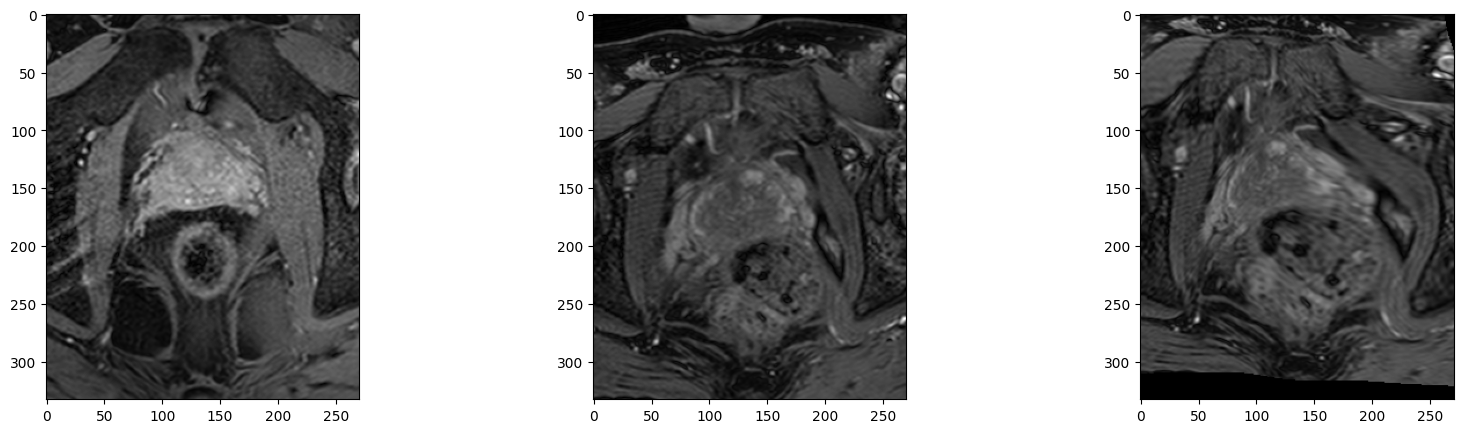

In [70]:
# currently it says slice_fixed, but this should be changed accordingly when it is combined with MI script
# define the path to the slice of the fixed image
path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60):
    # define the path to the slice of the moving image
    path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    
    # create a folder to store the results files
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # visualize the images  
    itk_image_fixed = sitk.ReadImage(path_fixed)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    result_path_bspline = os.path.join(output_file_path_bspline, 'result.0.mhd')   
    transformed_moving_image = imageio.imread(result_path_bspline)  
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image_array_fixed[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image[:,:], cmap='gray')

### JACOBIAN

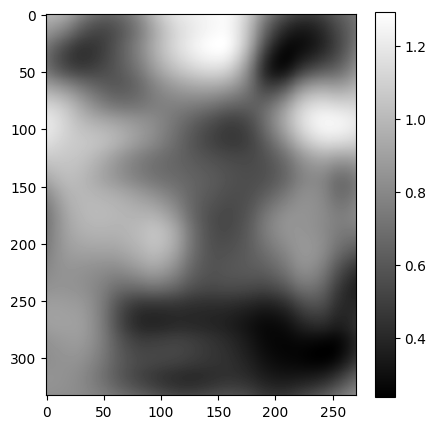

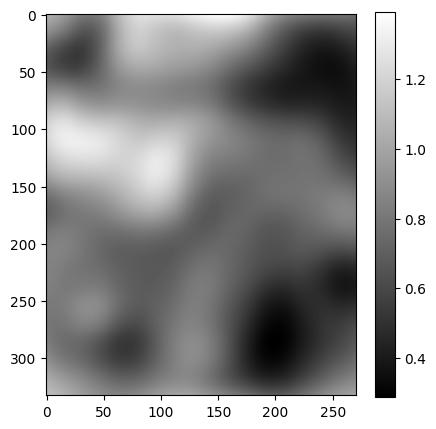

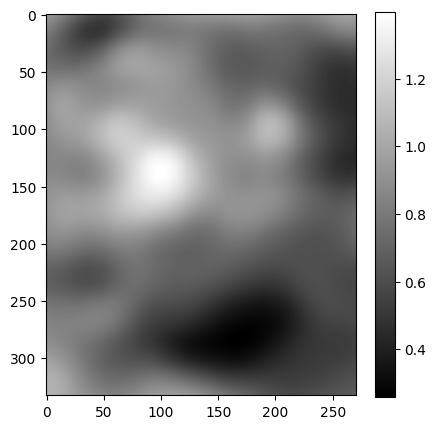

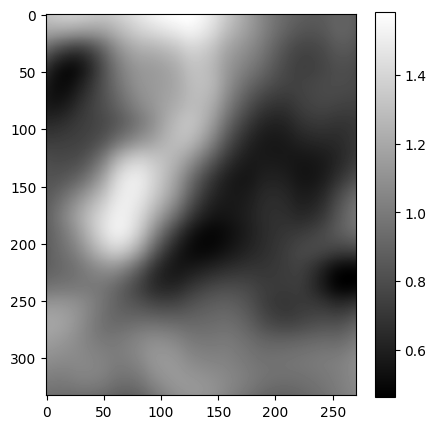

In [92]:
## THIS ONE BECOMES OBSOLETE BECAUSE A FUNCTION IS CREATED INSTEAD!

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving

for i in range(56,60):    
    # create a folder to store the results files
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # define the path to the transform parameters file
    transform_path_im = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # apply transformix
    tr = elastix.TransformixInterface(parameters=transform_path_im,
                                  transformix_path=TRANSFORMIX_PATH)
    
    # define the path to the output folder
    output_dir_jacobian = output_file_path_bspline
    jacobian_matrix_path = tr.jacobian_matrix(output_dir=output_dir_jacobian)
    
    # Get the Jacobian determinant
    jacobian_determinant_path = tr.jacobian_determinant(output_dir=output_dir_jacobian)
    
    # Get the full deformation field
    deformation_field_path = tr.deformation_field(output_dir=output_dir_jacobian)
    imb=imageio.imread(jacobian_determinant_path,level=0)
    
    # Visualize the Jacobian
    plt.figure(figsize=(5,5))
    pos=plt.imshow(imb[:,:],cmap='gray')
    plt.colorbar(pos)

In [96]:

def Jacobian(output_file_path_bspline):
    """
    Calculate the Jacobian.
    
    input:
    output_file_path_bspline: the path to the TransformParameters.0.txt file.
    
    output:
    imb: the Jacobian value.
    
    """
    # define the path to the transform parameters file
    transform_path_im = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # apply transformix
    tr = elastix.TransformixInterface(parameters=transform_path_im,
                                  transformix_path=TRANSFORMIX_PATH)
    
    # define the path to the output folder
    output_dir_jacobian = output_file_path_bspline
    jacobian_matrix_path = tr.jacobian_matrix(output_dir=output_dir_jacobian)
    
    # Get the Jacobian determinant
    jacobian_determinant_path = tr.jacobian_determinant(output_dir=output_dir_jacobian)
    
    # Get the full deformation field
    deformation_field_path = tr.deformation_field(output_dir=output_dir_jacobian)
    imb = imageio.imread(jacobian_determinant_path,level=0)
    
    return imb
    


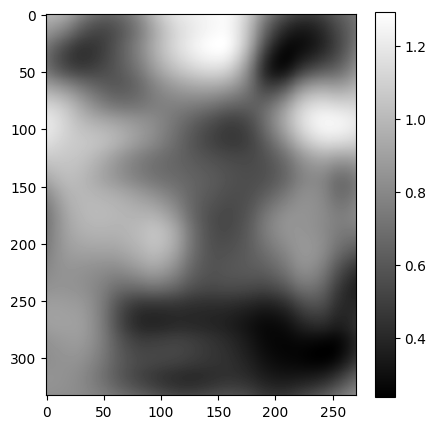

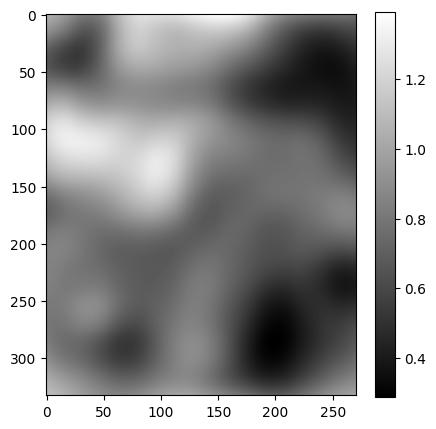

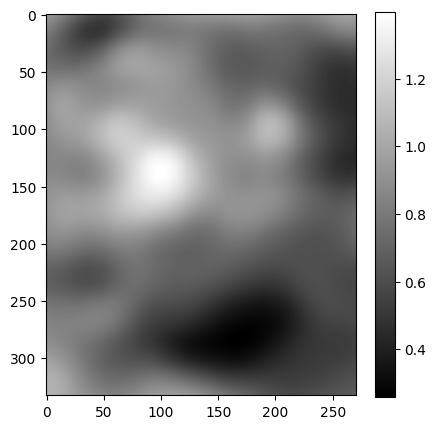

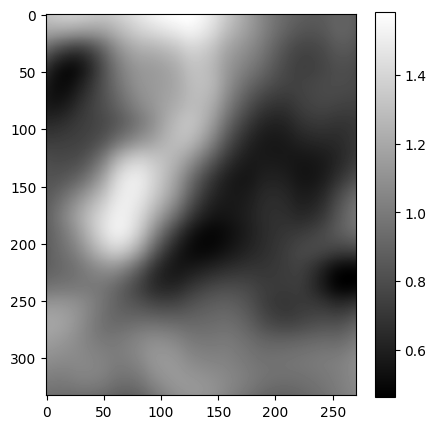

In [97]:
# THIS FOR-LOOP SHOULD BE CHANGED INTO THE RANGE OF MOVING SLICES THAT ARE USED, USE AN AUTOMATIC WAY INSTEAD OF NUMBERS

for i in range(56,60):    
    # create a folder to store the results files
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # calculate the Jacobian per slice
    imb_value = Jacobian(output_file_path_bspline)
    
    # visualize the Jacobian per slice
    plt.figure(figsize=(5,5))
    pos = plt.imshow(imb_value[:,:],cmap='gray')
    plt.colorbar(pos)
    


# Use transform matrix to get the corresponding masks

## Apply b-spline transformation to the masks

In [56]:
## THIS ONE BECOMES OBSOLETE BECAUSE A FUNCTION IS CREATED INSTEAD!

# create a 2D mask of each slice in the 3D mask

# we use: patient_fixed, patient_moving
fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_fixed)
moving_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_moving)

itk_image_fixed = sitk.ReadImage(fixed_mask_path)
itk_image_moving = sitk.ReadImage(moving_mask_path)

for i in range(86): 
    itk_img_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    slice = sitk.GetImageFromArray(itk_img_array_fixed[i,:,:])
    path_fixed = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
    sitk.WriteImage(slice,path_fixed)
    
    itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
    path_moving = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    sitk.WriteImage(slice,path_moving)



In [67]:
def create2DMasks(fixed_mask_path, moving_mask_path):
    """
    Create a 2D mask of each slice in the 3D mask.
    
    input: 
    fixed_mask_path: the path to the fixed mask slice. 
    moving_mask_path: the path to the moving mask slices.
    
    output:
    - 
    
    """
    itk_image_fixed = sitk.ReadImage(fixed_mask_path)
    itk_image_moving = sitk.ReadImage(moving_mask_path)
    
    # I kept the for-loop since one patient always contains 86 slices and it is so fast that I don't think it is necessary
    # to only create masks for certain slices
    for i in range(86): 
        # fixed mask
        itk_img_array = sitk.GetArrayFromImage(itk_image_fixed)
        slice = sitk.GetImageFromArray(itk_img_array[i,:,:])
        path_fixed = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
        sitk.WriteImage(slice,path_fixed)
    
        # moving image
        itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
        slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
        path_moving = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
        sitk.WriteImage(slice,path_moving)



In [68]:
fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_fixed)
moving_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_moving)

create2DMasks(fixed_mask_path, moving_mask_path)

In [57]:
## THIS ONE BECOMES OBSOLETE BECAUSE A FUNCTION IS CREATED INSTEAD!

# Create a copy of the 'TransformParameters.0.txt' and rename it to 'TransformParameters.0b.txt'
# In the new file, the (FinalBSplineInterpolationOrder 3) is changed to value 0

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60): 
    # create a folder to store the results files    
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # define the path to the transform parameters file
    transform_path = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # create a copy of the file and rename it
    target_path = os.path.join(output_file_path_bspline,'TransformParameters.0b.txt')
    shutil.copyfile(transform_path, target_path)
    
    # change the value from 3 to 0
    with open(target_path,'r') as file:
        data=file.read()
        data=data.replace("(FinalBSplineInterpolationOrder 3)", "(FinalBSplineInterpolationOrder 0)")
        
    with open(target_path,'w') as file:
        
        file.write(data)

In [98]:
def newTransformParameterFile(output_file_path_bspline):
    """
    Create a copy of the 'TransformParameters.0.txt' and rename it to 'TransformParameters.0b.txt'.
    In the new file, the (FinalBSplineInterpolationOrder 3) is changed to value 0.
    
    input:
    output_file_path_bspline: the path to the TransformParameters.0.txt file.
    
    output:
    - 
    
    """
    # define the path to the transform parameters file
    transform_path = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # create a copy of the file and rename it
    target_path = os.path.join(output_file_path_bspline,'TransformParameters.0b.txt')
    shutil.copyfile(transform_path, target_path)
    
    # change the value from 3 to 0
    with open(target_path,'r') as file:
        data=file.read()
        data=data.replace("(FinalBSplineInterpolationOrder 3)", "(FinalBSplineInterpolationOrder 0)")
        
    with open(target_path,'w') as file:
        
        file.write(data)


In [99]:
# THIS FOR-LOOP SHOULD BE CHANGED INTO THE RANGE OF MOVING SLICES THAT ARE USED, USE AN AUTOMATIC WAY INSTEAD OF NUMBERS

for i in range(56,60): 
    # create a folder to store the results files    
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    newTransformParameterFile(output_file_path_bspline)

C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_56
C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_57
C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_58
C:\Users\esmee\OneDrive - TU Eindhoven\2022 - 2023\Q3\8DM20\Project\TrainingData\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_59


In [58]:
# currently it says slice_fixed, but this should be changed accordingly when it is combined with MI script
# define the path to the slice of the fixed mask
path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60):
    # define the path to the slice of the moving mask
    path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    
    # define the path to the transform parameters file
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    target_path = os.path.join(output_file_path_bspline,'TransformParameters.0b.txt')
    
    # create a folder to store the results files    
    if not os.path.exists(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline_mask = os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # apply transformix
    tr = elastix.TransformixInterface(parameters=target_path,
                                  transformix_path=TRANSFORMIX_PATH)
    
    # transform the moving mask with the transformation parameters
    tr.transform_image(path_moving_mask, output_dir=output_file_path_bspline_mask)
    


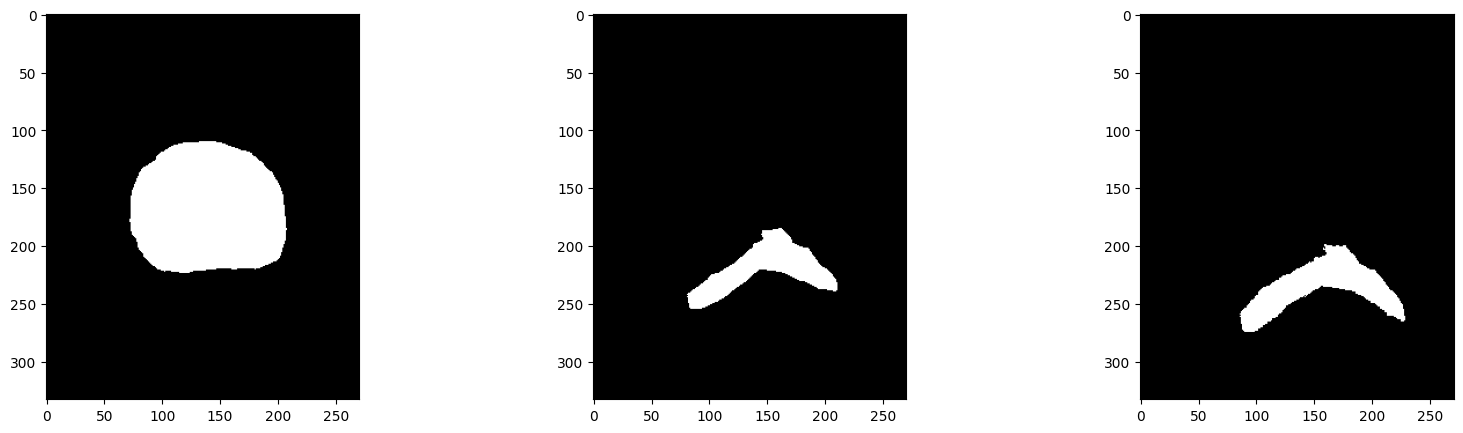

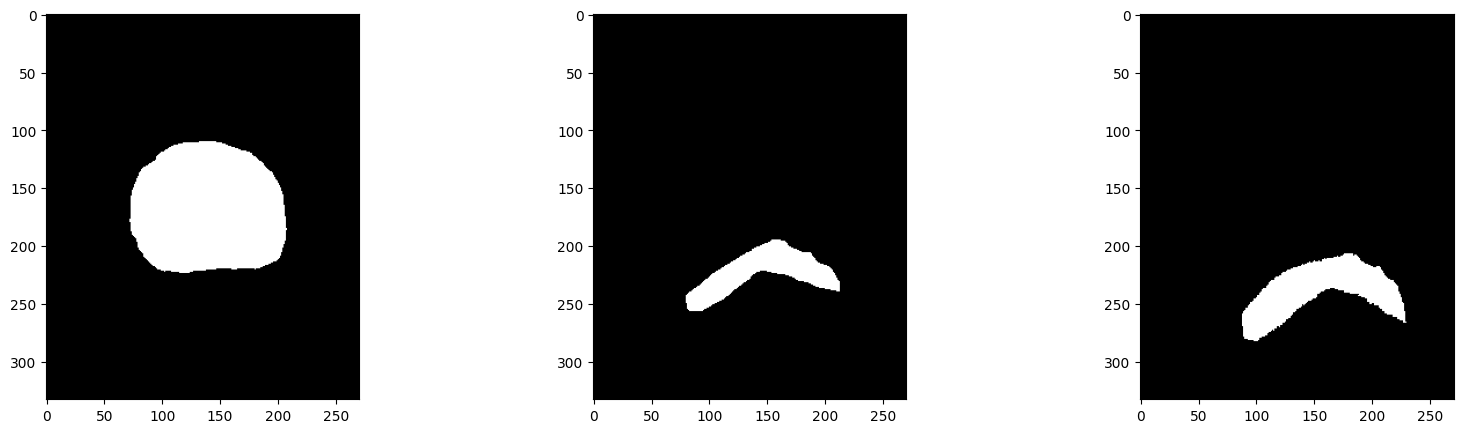

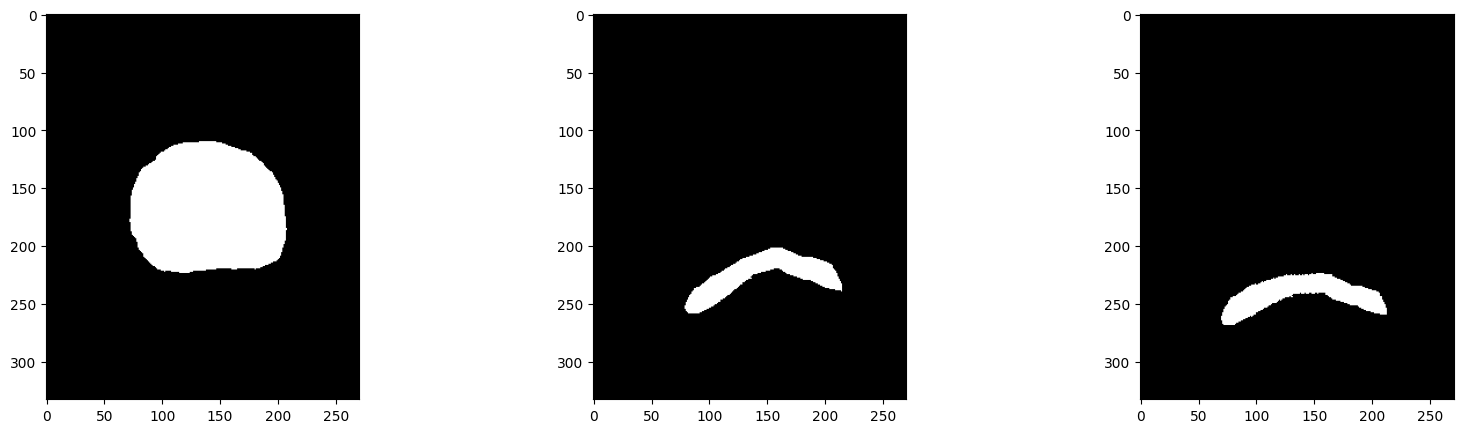

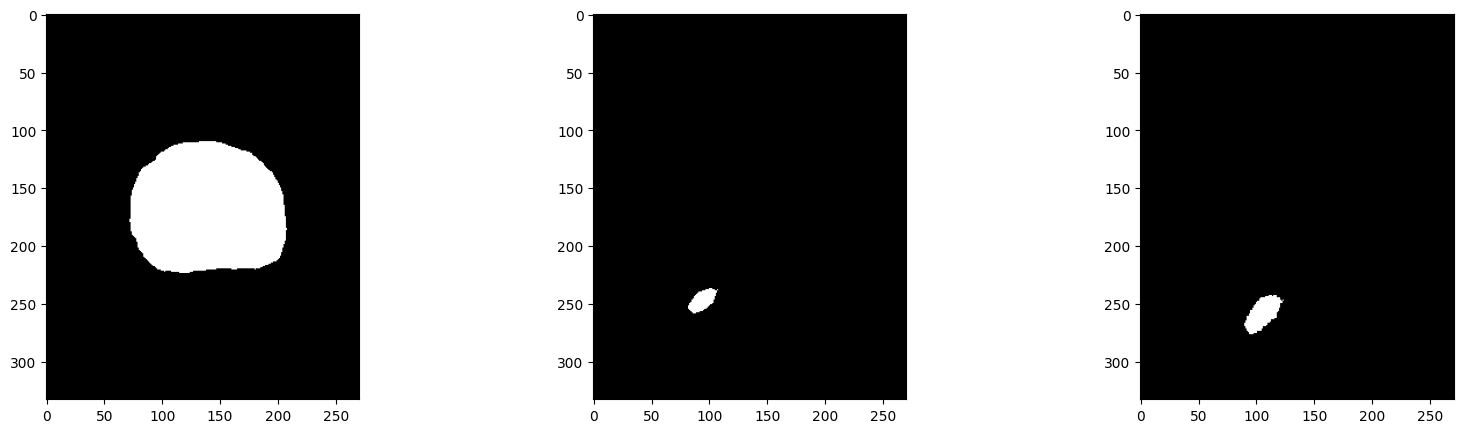

In [59]:
# currently it says patient_fixed and slice_fixed, but this should be changed accordingly when it is combined with MI script
# define the path to the slice of the fixed mask
path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60):
    # define the path to the slice of the moving mask
    path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    
    # create a folder to store the results files   
    if not os.path.exists(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))))
    output_file_path_bspline_mask = os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i)))
    
    # visualize the images  
    itk_image_fixed = sitk.ReadImage(path_fixed_mask)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving_mask)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    result_path_bspline_mask = os.path.join(output_file_path_bspline_mask, 'result.mhd')
    transformed_moving_image = imageio.imread(result_path_bspline_mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image_array_fixed[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image[:,:], cmap='gray')

## Visualize the masks over the images

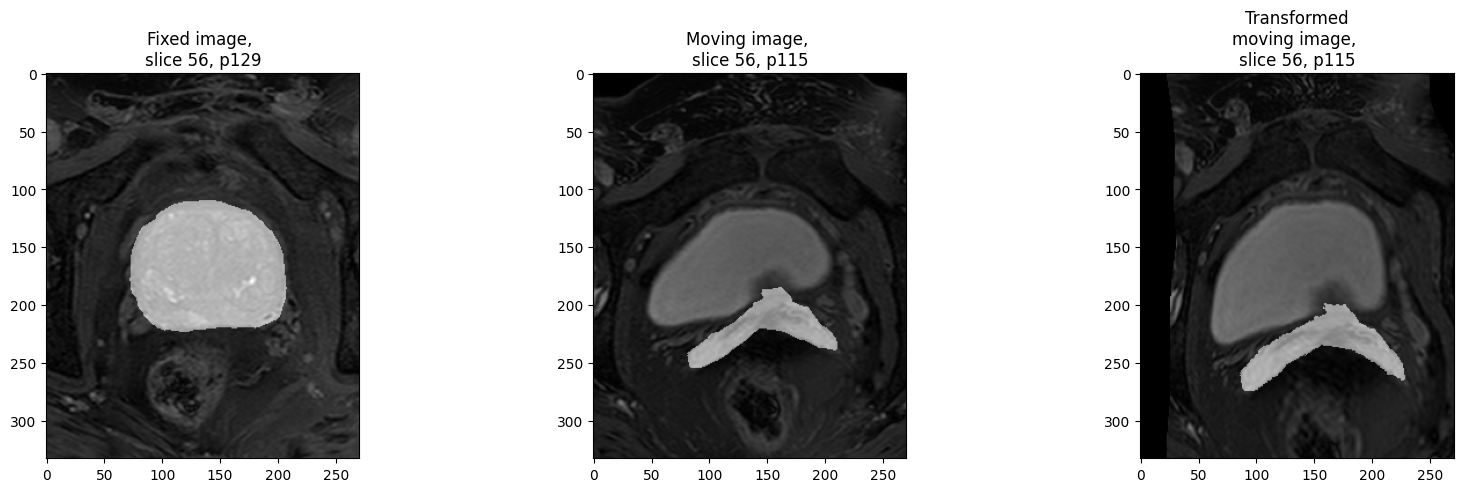

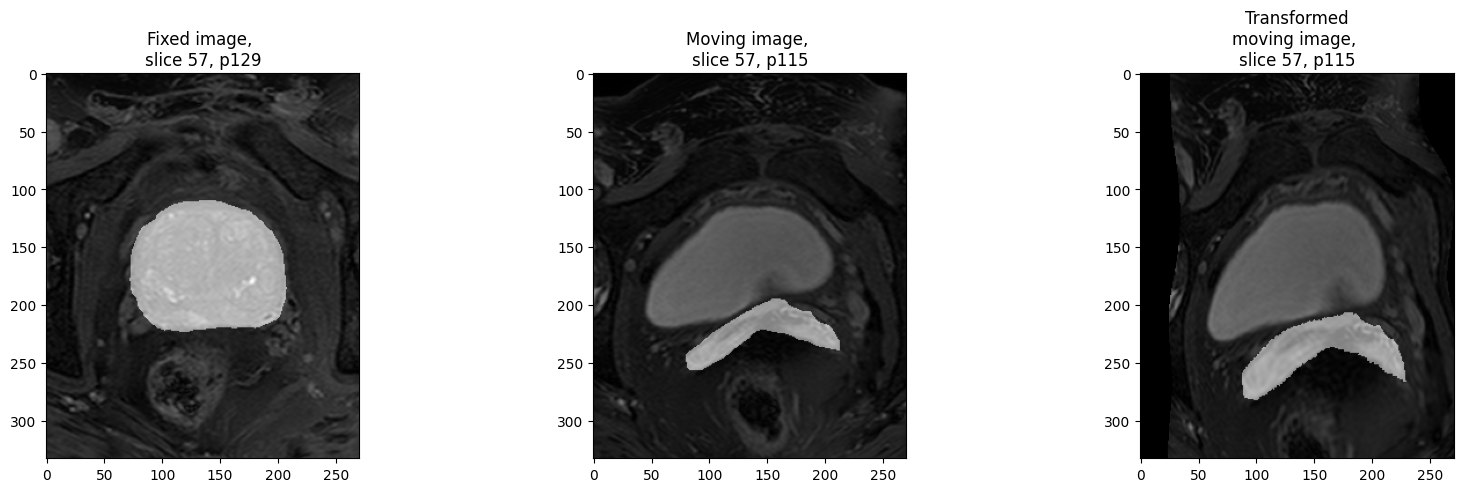

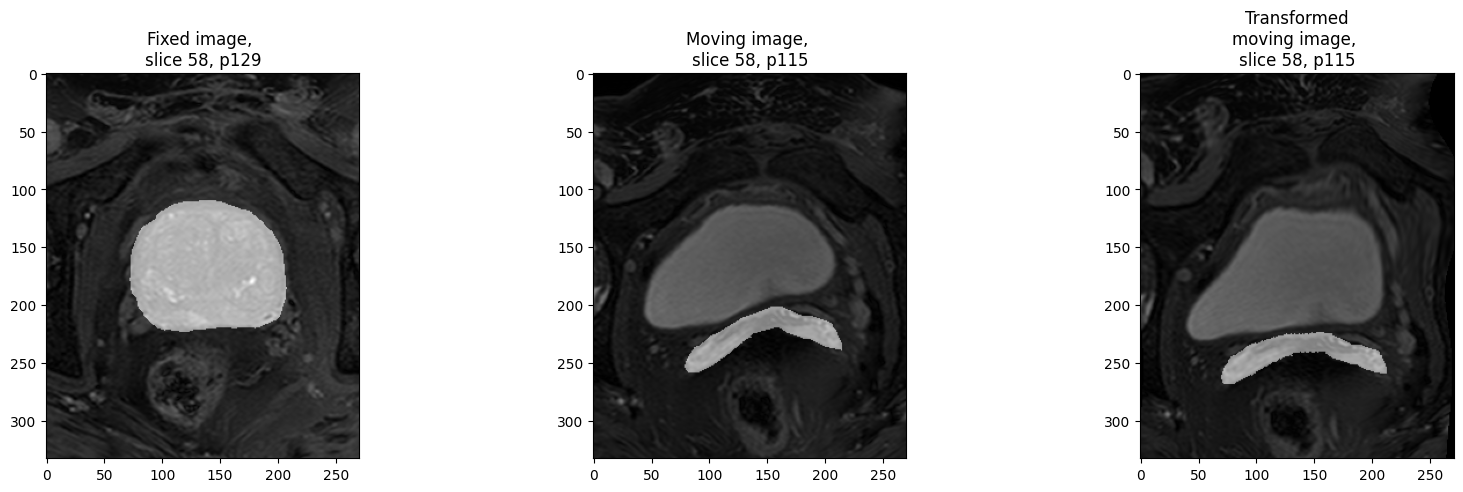

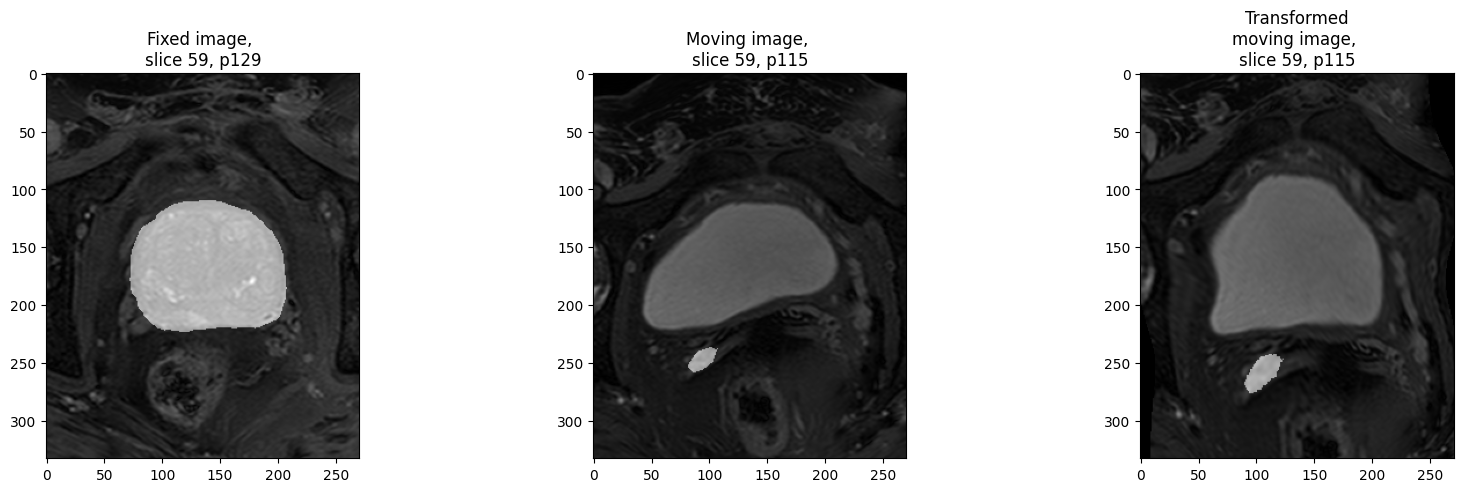

In [60]:
# currently it says patient_fixed and slice_fixed, but this should be changed accordingly when it is combined with MI script
# define the path to the slice of the fixed image and mask
path_fixed_IM = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)
path_fixed_MASK = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

# instead of manually adjusting this range, this should be the range of the moving slices
# in this for-loop we use: patient_fixed, slice_fixed, patient_moving
for i in range(56,60):
    # define the path to the slice of the moving image
    path_moving_IM = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    output_file_path_IM = os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))   
    result_path_IM = os.path.join(output_file_path_IM, 'result.0.mhd')
    
    # define the path to the slice of the moving mask
    path_moving_MASK = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
    output_file_path_MASK = os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,i))
    result_path_MASK = os.path.join(output_file_path_MASK, 'result.mhd')
    
    # read the images
    readable_fixed_image_path_IM = imageio.imread(path_fixed_IM)
    readable_moving_image_path_IM = imageio.imread(path_moving_IM)
    transformed_moving_image_IM = imageio.imread(result_path_IM)
    
    # read the masks
    itk_image_fixed = sitk.ReadImage(path_fixed_MASK)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving_MASK)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    transformed_moving_image_MASK = imageio.imread(result_path_MASK)
    
    # visualize the images
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    ax[0].imshow(readable_fixed_image_path_IM[:,:], cmap='gray')
    ax[0].imshow(image_array_fixed[:,:], cmap='gray', alpha=0.5)
    ax[0].set_title('Fixed image, \nslice {}, {}'.format(i, patient_fixed))
    
    ax[1].imshow(readable_moving_image_path_IM[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray', alpha=0.5)
    ax[1].set_title('Moving image, \nslice {}, {}'.format(i, patient_moving))
    
    ax[2].imshow(transformed_moving_image_IM[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image_MASK[:,:], cmap='gray', alpha=0.5)
    ax[2].set_title('Transformed\nmoving image, \nslice {}, {}'.format(i, patient_moving))
    
    plt.show()